# Let the Game Begin

7.22 Dota version immediately after TI9

## Loading Screen

###### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import random

import urllib.request
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

###### Widen screen 

In [2]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

###### Load Heroes Data

In [3]:
with urlopen('https://raw.githubusercontent.com/dqa611/Dota2_analysis/master/dota2_heroes.csv') as csv_file:
    heroes_name_fixed = pd.read_csv(csv_file)

###### Load Hero Attributes Data

In [4]:
with urlopen('https://raw.githubusercontent.com/dqa611/Dota2_analysis/master/dota2_heroes_roles.csv') as csv_file:
    heroes_roles = pd.read_csv(csv_file)

###### Load Matchup Data

In [5]:
import json
with urlopen('https://raw.githubusercontent.com/dqa611/Dota2_analysis/master/heroes_matchup_score.json') as json_file:
    matchup_score1 = json.load(json_file)

###### Load Combo Data

In [6]:
import json
with urlopen('https://raw.githubusercontent.com/dqa611/Dota2_analysis/master/heroes_good_with_score.json') as json_file:
    good_with_score1 = json.load(json_file)

###### Load Carry Laning Table

In [7]:
carry_laning_tbl = pd.read_csv('C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/Carries_laning_growth.csv')

# Functions

### Function to Create a Banned Hero Pool

In [8]:
def discard_pool(discard_pool):
    remaining_pool = [value for value in heroes_name_list if value not in discard_pool]
    return remaining_pool

### Function to Pick Ban Hero

In [88]:
def enter_input(print_out):
    while True:
        try:
            select_hero = input(str(print_out+ ': '))
            if select_hero == '':
                select_hero_output = ''
                break
            else:
                select_hero_list = select_hero.split(',')
                select_hero_output = [hero_name_process(select_hero_list[i])[0] for i in range(len(select_hero_list))]
                break
        except ValueError:
            print('Shortcut name invalid. Try again')
            continue
    return select_hero_output   

In [10]:
def ban_pick(print_out):
    while True:
        try:
            select_hero = input(str(print_out+ ': '))
            select_hero = hero_name_process(select_hero)  
        except ValueError:
            print('Shortcut name invalid. Try again')
            continue 

        if select_hero in discard_pool:
            print('Hero has been selected. Please select another one')
            continue
        else:
            discard_pool.append(select_hero)
            print('Discard hero list: ')
            print(discard_pool)
            print('Hero selected: ')
            print(select_hero)   
            print('\n')
            break
    return select_hero

### Function Process Hero Shortcut name

In [11]:
def hero_name_process(hero_list_raw):
    hero_list_raw = hero_list_raw.split(',')
    hero_list_raw1 = [str(item).strip() for item in hero_list_raw]

    hero_list = []

    for i in range(len(hero_list_raw)):
        hero_list.append(heroes_name_fixed[heroes_name_fixed['key'] == hero_list_raw1[i]]['Heroes'].item())
        
    return hero_list

### Function to calculate Radiant Counter Score vs Dire

In [12]:
def counter_score(radiant_team, dire_team):
    radiant_counter_score = 0 

    for hero_radiant in radiant_team:
        for hero_dire in dire_team:
            radiant_counter_score += [y for y in matchup_score1 if hero_radiant in y[0][0] and hero_dire in y[0][1]][0][1]

    radiant_team_pair = list(itertools.combinations(radiant_team,2))
    radiant_good_with_score = 0

    for i in range(len(radiant_team_pair)):
        radiant_good_with_score += [y for y in good_with_score1 if \
                                    radiant_team_pair[i][0] in y[0][0] and \
                                    radiant_team_pair[i][1] in y[0][1]][0][1]

    dire_team_pair = list(itertools.combinations(dire_team,2))
    dire_good_with_score = 0

    for i in range(len(dire_team_pair)):
        dire_good_with_score += [y for y in good_with_score1 if \
                                    dire_team_pair[i][0] in y[0][0] and \
                                    dire_team_pair[i][1] in y[0][1]][0][1]

    radiant_total_score = radiant_counter_score + radiant_good_with_score - dire_good_with_score

    return radiant_total_score

### Function to calculate individual Hero counter score vs other heroes

In [13]:
def hero_counter_score(hero):
    if hero in radiant_team: 
        team = radiant_team
        opponent = dire_team
    if hero in dire_team:
        team = dire_team 
        opponent = radiant_team

    hero_counter_score_list = []
    for opponent in opponent:
        hero_counter_score_list += [y for y in matchup_score1 if hero in y[0][0] and opponent in y[0][1]]
        
    hero_counter_score = []
    for i in range(len(hero_counter_score_list)):
        hero_counter_score.append(hero_counter_score_list[i][1])

    hero_counter_score = sum(hero_counter_score)

    return hero_counter_score_list, hero_counter_score

### Function to set up the initial game by role

- Filter only played heroes
- Calculate Complexity. High Complexity point is a constant minus to the team
- In calculating the score of the two teams, Complexity is excluded
- Each hero has different attributes and the number of attributes are not equal. To balance, heroes with high total # of attributes will be nerfed with smaller starting attribute points. Heroes with a lot of attribute points will be rewarded later in the game
- A Carry's natural Support point will be a fixed value
- An Utility's natural Support and Carry point will be a fixed value
- A Support's natural Carry point will be a fixed value

In [14]:
def initial_setup(heroes_roles):
    # Filter only played heroes
    global heroes_roles_not_adj_yet
    heroes_roles_not_adj_yet = heroes_roles.loc[heroes_roles['Hero Fullname'].isin(heroes_played)]

    # Calculate Complexity versus point. Will use later
    radiant_complexity = heroes_roles_not_adj_yet.loc[heroes_roles_not_adj_yet['Hero Fullname'].isin(radiant_team) & heroes_roles_not_adj_yet['Role'].isin(['Complexity'])]['Level'].sum()
    dire_complexity = heroes_roles_not_adj_yet.loc[heroes_roles_not_adj_yet['Hero Fullname'].isin(dire_team) & heroes_roles_not_adj_yet['Role'].isin(['Complexity'])]['Level'].sum()

    global radiant_vs_dire_complexity
    radiant_vs_dire_complexity = radiant_complexity - dire_complexity 

    # Filter out Complexity Points, for calculating round score
    heroes_roles_not_adj_yet = heroes_roles_not_adj_yet.loc[heroes_roles_not_adj_yet['Role'] != 'Complexity']

    heroes_lvl_0 = heroes_roles_not_adj_yet.copy()
    heroes_lvl_0 = heroes_lvl_0.reset_index(drop=True)

    # Formula to nerf heroes with a lot of attribute down
    for hero in heroes_played:
        for role in role_list:
            if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname']==hero) & (heroes_lvl_0['Role']==role), 'Level'].item() >0:
                heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname']==hero) & (heroes_lvl_0['Role']==role), 'Level'] = \
                    1 - (heroes_roles_not_adj_yet.loc[heroes_roles_not_adj_yet['Hero Fullname']==hero, 'Level'].sum())*initial_setup_dict['initial_attr_reduction_rate']

    # First rule set
    for hero in combined_role['Carry']:
        if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'].item() >0:
            heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'] = initial_setup_dict['support_point_for_carry'] 

    for hero in combined_role['Utility']:
        if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'].item() >0:
            heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'] = initial_setup_dict['carry_point_for_utility']    
        heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'] = initial_setup_dict['support_point_for_utility']    
    
    for hero in combined_role['Support']:
        if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'].item() >0:
            heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'] =initial_setup_dict['carry_point_for_support']       
    # Give back support original point
        if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'].item() >0:
            heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'] = \
                heroes_roles.loc[(heroes_roles['Hero Fullname'] == hero) & (heroes_roles['Role'] == 'Support'), 'Level'].item()      
            
    return heroes_lvl_0

### Function to return Heroes' attributes

In [15]:
def hero_score(hero, hero_level_input, attr):
    if attr == 'all':
        return hero_level_input.loc[(hero_level_input['Hero Fullname'] == hero)].reset_index(drop=True)
    if '!' in attr:
        return hero_level_input.loc[(hero_level_input['Hero Fullname'] == hero) & (hero_level_input['Role'] != attr)].reset_index(drop=True)
    else:
        return hero_level_input.loc[(hero_level_input['Hero Fullname'] == hero) & (hero_level_input['Role'] == attr)].reset_index(drop=True)  

### Function to calculate Round Score 
The function could input the entire two team, or just 2 heroes on each team.

In each stage of the game, some scores will be excluded out, but will be included back in with grow score included in there

In [16]:
def round_score(radiant_input, dire_input, hero_level_input, stage):
    def round_score1(radiant_input, dire_input, hero_level_input):
        radiant_role_combined = hero_level_input[hero_level_input['Hero Fullname'].isin(radiant_input)]
        radiant_role_score = radiant_role_combined.groupby(['Role'])['Level'].sum().reset_index()
        radiant_role_score = radiant_role_score.rename(columns={'Level': 'Radiant_role_score'})

        dire_role_combined = hero_level_input[hero_level_input['Hero Fullname'].isin(dire_input)]
        dire_role_score = dire_role_combined.groupby(['Role'])['Level'].sum().reset_index()
        dire_role_score = dire_role_score.rename(columns={'Level': 'Dire_role_score'})

        role_score_table = pd.merge(left = radiant_role_score, \
                                    right = dire_role_score, \
                                    on='Role', how='outer').fillna(0)
        return role_score_table

    role_score_table1 = pd.DataFrame()
    
    # If left as default, all points are considered
    if stage == 'default':
        hero_level_input = heroes_roles_not_adj_yet[:]
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[:]
        
    if stage == 'early':
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[~role_score_table['Role'].isin(early_attr_remove)].reset_index(drop=True)
        
    if stage == 'mid':
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[~role_score_table['Role'].isin(midgame_attr_remove)].reset_index(drop=True)


    if stage == 'late':
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[~role_score_table['Role'].isin(lategame_attr_remove)].reset_index(drop=True)
        
        
    role_score_table1['radiant_vs_dire'] = role_score_table1['Radiant_role_score'] - \
                                          role_score_table1['Dire_role_score']
    
    role_score = round(role_score_table1['radiant_vs_dire'].sum(),2)
    return role_score_table1, role_score

### Function to adjust Laning Point for Roamer

Roamer's attributes will be divided by 3 and added to each lane. This helps the laning stage of the team stronger yet the hero will have lower initial growth

In [17]:
def laning_stage(laning):    
    early_game_score_raw = round_score(laning[0], laning[1], heroes_roles_not_adj_yet, 'early')

    # Radiant additonal points for having a roamer
    if radiant_heroes_lane['Roam'] != '': 
        radiant_roam_point = hero_score(radiant_heroes_lane['Roam'][0], heroes_roles_not_adj_yet, 'all')
        radiant_roam_point['Level'] = radiant_roam_point['Level'] / 3 
        radiant_roam_point = radiant_roam_point[radiant_roam_point['Role'].isin(['Escape', 'Disabler', 'Nuker', 'Support'])].reset_index(drop=True)
        radiant_roam_point = radiant_roam_point.rename(columns={'Level': 'radiant_roam_point'})
    else: 
        radiant_roam_point = pd.DataFrame(columns=['Role', 'radiant_roam_point']) 

    # Dire additonal points for having a roamer    
    if dire_heroes_lane['Roam'] != '': 
        dire_roam_point = hero_score(dire_heroes_lane['Roam'][0], heroes_roles_not_adj_yet, 'all')

        dire_roam_point['Level'] = dire_roam_point['Level'] / 3 
        dire_roam_point = dire_roam_point[dire_roam_point['Role'].isin(['Escape', 'Disabler', 'Nuker', 'Support'])].reset_index(drop=True)
        dire_roam_point = dire_roam_point.rename(columns={'Level': 'dire_roam_point'})
    else: 
        dire_roam_point = pd.DataFrame(columns=['Role', 'dire_roam_point'])

    early_game_score1 = early_game_score_raw[0].merge(radiant_roam_point, on='Role', how='outer').fillna(0)
    early_game_score2 = early_game_score1.merge(dire_roam_point, on='Role', how='outer').fillna(0)

    early_game_score2['versus_score'] = early_game_score2['Radiant_role_score'] + early_game_score2['radiant_roam_point'] - \
                                             early_game_score2['Dire_role_score'] - early_game_score2['dire_roam_point']

    bonus_laning_point = round(early_game_score2['versus_score'].sum(),1)
    
    # Set a cap bonus point of 5
    if bonus_laning_point >=5:
        bonus_laning_point =5
    else: bonus_laning_point = bonus_laning_point
    
    return early_game_score2, bonus_laning_point, -bonus_laning_point, laning[0], laning[1]

### Function adding Counter points in Laning

Counter point is among heroes in the lane. If the lane is a 2v2, then each hero will be paired to calculate counter score, then add together

In [18]:
def counter_laning(bonus_laning_point_list):
    counter_laning_bot1 = []
    counter_laning_mid1 = []
    counter_laning_top1 = []

    for radiant in range(len(bonus_laning_point_list['Bot'][3])):   
        for dire in range(len(bonus_laning_point_list['Bot'][4])):
            counter_laning_bot1.append([y[1] for y in matchup_score1 if bonus_laning_point_list['Bot'][3][radiant] in y[0][0] and bonus_laning_point_list['Bot'][4][dire] in y[0][1]])  
    counter_laning_bot = list(itertools.chain(*counter_laning_bot1))

    for radiant in range(len(bonus_laning_point_list['Mid'][3])):   
        for dire in range(len(bonus_laning_point_list['Mid'][4])):
            counter_laning_mid1.append([y[1] for y in matchup_score1 if bonus_laning_point_list['Mid'][3][radiant] in y[0][0] and bonus_laning_point_list['Mid'][4][dire] in y[0][1]])  
    counter_laning_mid = list(itertools.chain(*counter_laning_mid1))

    for radiant in range(len(bonus_laning_point_list['Top'][3])):   
        for dire in range(len(bonus_laning_point_list['Top'][4])):
            counter_laning_top1.append([y[1] for y in matchup_score1 if bonus_laning_point_list['Top'][3][radiant] in y[0][0] and bonus_laning_point_list['Top'][4][dire] in y[0][1]])  
    counter_laning_top = list(itertools.chain(*counter_laning_top1))

    global counter_laning_score
    counter_laning_score = dict.fromkeys(['counter_laning_mid_score', 'counter_laning_mid_score', 'counter_laning_mid_score'])
    counter_laning_score.update(counter_laning_mid_score = sum(counter_laning_mid))
    counter_laning_score.update(counter_laning_bot_score = sum(counter_laning_bot))
    counter_laning_score.update(counter_laning_top_score = sum(counter_laning_top))
    
    return counter_laning_score

### Function to Level Up Hero 1 

- Bonus laning point is based on the hero's laning
- Roamer and Jungler won't get laning bonus
- Unnatural Support and Carry will have a lower growth than natural ones
- Support's Support point will have a different growth compared to Support's UnSupport point
- Carry's Carry point will have a different growth (a growth table) compared to Carry's UnCarry point
- This applies to all hero's growth until the lategame stage

In [19]:
def heroes_level_up1(hero): 

    hero_level = hero_score(hero, heroes_lvl_0, 'all')
    hero_lvl1 = hero_level.copy()

    # Bonus Laning Point
    global bonus_laning_point
    bonus_laning_point = 0

    if hero in lane_matchup_flatlist['Mid'] and hero in radiant_team:
        bonus_laning_point = bonus_laning_point_list['Mid'][1] + counter_laning(bonus_laning_point_list)['counter_laning_mid_score']*laning_counter_matchup_multiplier
    if hero in lane_matchup_flatlist['Mid'] and hero in dire_team:
        bonus_laning_point = bonus_laning_point_list['Mid'][2] - counter_laning(bonus_laning_point_list)['counter_laning_mid_score']*laning_counter_matchup_multiplier

    if hero in lane_matchup_flatlist['Bot'] and hero in radiant_team:
        bonus_laning_point = bonus_laning_point_list['Bot'][1] + counter_laning(bonus_laning_point_list)['counter_laning_bot_score']*laning_counter_matchup_multiplier
    if hero in lane_matchup_flatlist['Bot'] and hero in dire_team:
        bonus_laning_point = bonus_laning_point_list['Bot'][2] - counter_laning(bonus_laning_point_list)['counter_laning_bot_score']*laning_counter_matchup_multiplier

    if hero in lane_matchup_flatlist['Top'] and hero in radiant_team:
        bonus_laning_point = bonus_laning_point_list['Top'][1] + counter_laning(bonus_laning_point_list)['counter_laning_top_score']*laning_counter_matchup_multiplier
    if hero in lane_matchup_flatlist['Top'] and hero in dire_team:
        bonus_laning_point = bonus_laning_point_list['Top'][2] - counter_laning(bonus_laning_point_list)['counter_laning_top_score']*laning_counter_matchup_multiplier

    # If the Bonus Laning Point causes the growth to be less than 1, the growth is 1
    # This situation is rare because the points needs to be at least 50 points to cause it 
    # Hero Level Up

    # Jungler doesn't get bonus laning stage but fixed growth instead   
    if hero in combined_laning_stage['Jungle']:
        # unnatural jungler
        if 'Jungler' not in heroes_roles.loc[heroes_roles['Hero Fullname']==hero, 'Role'] and hero in combined_role['Jungle']: 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * growth_rate_laning['jungler_unnatural_rate']
        else: #natural jungler
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * growth_rate_laning['jungler_natural_rate']

    # Roamer doesn't get bonus laning stage because its attr points already spread out all lanes. Get a fixed growth
    if hero in combined_laning_stage['Roam']:
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * growth_rate_laning['roamer_rate']

    # Utility (non support and non carry) will get a small growth rate plus or minus bonus laning points
    if hero in combined_role['Utility']:
        hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (~hero_lvl1['Role'].isin(['Carry', 'Support'])), 'Level'] = \
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (~hero_lvl1['Role'].isin(['Carry', 'Support'])), 'Level'] * (growth_rate_laning['utility_rate'] + bonus_laning_point*laning_bonus_fixed_rate)

    # Natural support hero will get bonus support rate plus bonus laning points
    if hero in combined_role['Support']:
        # unnatural support
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Support', 'Level'].item() ==0 \
        and hero in combined_role['Support']: 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * (growth_rate_laning['support_unnatural'] + bonus_laning_point*laning_bonus_fixed_rate)                
        else: # natural support 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == 'Support'), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == 'Support'), 'Level'] * (growth_rate_laning['support_natural_support'] + bonus_laning_point*laning_bonus_fixed_rate)

            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Support'), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Support'), 'Level'] * (growth_rate_laning['support_natural_others'] + bonus_laning_point*laning_bonus_fixed_rate)


    # Natural carry hero will get bonus carry rate plus bonus laning points
    if hero in combined_role['Carry']:
        # unnatural carry
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Carry', 'Level'].item() ==0 \
        and hero in combined_role['Carry']:
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * (growth_rate_laning['carry_unnatural'] + bonus_laning_point*laning_bonus_fixed_rate) #maximum grow is 1.65
        else: # natural carry 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == 'Carry'), 'Level'] = \
                carry_laning_tbl.loc[(carry_laning_tbl['natural_carry_point']== heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero) & (heroes_roles_not_adj_yet['Role'] == 'Carry'), 'Level'].item()) & \
                                     (carry_laning_tbl['laning_bonus']==bonus_laning_point), 'carry_point_after_laning'].item() 

            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Carry'), 'Level'] =  \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Carry'), 'Level'] * (growth_rate_laning['carry_natural_others'] + bonus_laning_point*laning_bonus_fixed_rate)
    for role in role_list:
        if hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == role), 'Level'].item() < \
                heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == role), 'Level'].item():
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == role), 'Level'] = \
                heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == role), 'Level'].item()
            
    return hero_lvl1

### Function To Create a Table with new Score for Next Round Use

In [20]:
def heroes_lvl_up_tbl(function):
    table_name = pd.DataFrame()
    
    for hero in heroes_played:
        table_name = pd.concat([table_name, function(hero)])
    table_name = table_name.reset_index(drop=True)
    return table_name

### Function to Level Up Hero 2

- No more laning bonus here, only bonus at the end of early game
- Different growth than growth at the laning stage

In [21]:
def heroes_lvl_up2(hero):
    hero_level = hero_score(hero, heroes_lvl_20, 'all')
    hero_lvl2 = hero_level.copy()

    if hero in combined_role['Utility']:
        hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (~hero_lvl2['Role'].isin(['Carry', 'Support'])), 'Level'] = \
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (~hero_lvl2['Role'].isin(['Carry', 'Support'])), 'Level'] * (growth_rate_midgame['utility_rate'] + bonus_round20_point*round20_bonus_fixed_rate)

    if hero in combined_role['Support']:
        # unnatural support
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Support', 'Level'].item() ==0 \
        and hero in combined_role['Support']: 
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] = hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] * (growth_rate_midgame['support_unnatural'] + bonus_round20_point*round20_bonus_fixed_rate)                
        else: # natural support 
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Support'), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Support'), 'Level'] * (growth_rate_midgame['support_natural_support'] + bonus_round20_point*round20_bonus_fixed_rate)

            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Support'), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Support'), 'Level'] * (growth_rate_midgame['support_natural_others'] + bonus_round20_point*round20_bonus_fixed_rate)

    # Natural carry hero will get bonus carry rate plus bonus laning points
    # Unnatural carry hero will get fixed growth
    if hero in combined_role['Carry']:
        # unnatural carry
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Carry', 'Level'].item() ==0 \
        and hero in combined_role['Carry']:
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] * (growth_rate_midgame['carry_unnatural'] + bonus_round20_point*round20_bonus_fixed_rate)
        else: # natural carry 
            carry_natural_point = hero_score(hero, heroes_roles, 'all')['Level'][0]
            
            # carry point formula. This has a huge impact on carry growth
            carry_growth_rate = midgame_carry_point[carry_natural_point-1] + ((carry_natural_point*10 + bonus_round20_point)*round20_bonus_fixed_rate)

            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Carry'), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Carry'), 'Level'] * carry_growth_rate

            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Carry'), 'Level'] =  \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Carry'), 'Level'] * (growth_rate_midgame['carry_natural_others'] + bonus_round20_point*round20_bonus_fixed_rate)

    return hero_lvl2

### Function to Boost bonus based on Strategy

- 4 options: Aggressive, Turtle, Normal or Random
- Aggressive strategy will greatly boost the heroes initially before entering the combat stage, but later on the hero will grow slower 
- Turtle strategy will no give a boost to the heroes initially, but later on the hero will greater growth if winning combats
- Normal strategy is between the 2

In [22]:
def strategy_bonus_rate(team, strategy):
    
    hero_level_boosted = heroes_lvl_1.copy()
    
    if strategy == 'random':
        strategy = random.choice(['aggressive', 'turtle', 'normal'])
    
    # Boost hero's midgame aggressive strategy bonus
    if strategy == 'aggressive':
        for hero in team:
            hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] = \
                hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] * strategy_bonus_rate_dict['team_midgame_aggressive_rate'] 
    
    # Boost hero's midgame balance strategy bonus
    if strategy == 'normal':
        for hero in team:
            hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] = \
                hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] * strategy_bonus_rate_dict['team_normal_rate']

    # Boost hero's midgame turtle strategy bonus        
    if strategy == 'turtle':
        for hero in list(set(team).intersection(combined_role['Carry'])):
            hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] = hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] * strategy_bonus_rate_dict['team_midgame_turtle_rate']
                       
    return hero_level_boosted

### Strategy Penalty Function

In [23]:
def strategy_penalty(previous_level_input, winner_team_input):
    previous_level = previous_level_input.copy()

    if winner_team_input == radiant_team:
        for hero in radiant_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[radiant_strategy+'_reward']
        for hero in dire_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[dire_strategy+'_penalty']        

    if winner_team_input == dire_team:
        for hero in radiant_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[radiant_strategy+'_penalty']
        for hero in dire_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[dire_strategy+'_reward']    
    
    if winner_team_input != radiant_team and winner_team_input != dire_team:
        for hero in radiant_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[radiant_strategy+'_reward']
        for hero in dire_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[dire_strategy+'_reward']                          
    return previous_level

### Boost for Winner(s)

After winning combat, the winning team will receive a random bonus boost. Some boosts are for the combat survivors only, some are for the entire team:

1) Among the survivors, boost a random role. Add each >0 attributes by a fixed number. The number however will be divided by the number of heroes in the role. 

2) Among the survivors, boost a random hero. Increase the hero's attributes by a rate

3) Boost the survivors by a rate

4) Boost the team's counter score by a number

5) Boost the maximum cap attribute of the entire team by a number

6) Among the survivors, boost a random hero with a new attribute

In [24]:
def boost_option_explained(boost_option):
    if boost_option == 1:
        return print('Boost a role in the winner team for each attribute by ' + str(combat_boost_rate['role_boost_rate']) + ' if the natural point is >0. The bonus is divided by the number of heroes in the role')
    if boost_option == 2:
        return print('Boost a random survivor in the winner team by ' + str(combat_boost_rate['hero_boost_rate']))
    if boost_option == 3:
        return print('Boost the winner team survivors by ' + str(combat_boost_rate['team_boost_rate']))
    if boost_option == 4:
        return print('Boost the counter score of ' + str(combat_boost_rate['counter_boost_rate']) + ' permanently to the winner team. No bonus point thou')
    if boost_option == 5:
        return print('Boost the cap attribute ' + str(combat_boost_rate['cap_boost']) + ' permanently to the winner team. No bonus point thou')    
    if boost_option == 6:
        return print('Boost a random hero 0-attribute by ' + str(combat_boost_rate['attribute_boost'])  + ' permanently to the hero. No bonus point thou')

In [25]:
def boost_for_winner(option_number, previous_level, winner_team, survivors):
    
    hero_level2_boosted = previous_level.copy()
    role_random_selected = random.choice(['Carry', 'Support', 'Utility'])
    heroes_survivors = list(set(winner_team).intersection(survivors))
    global hero_random_selected
    hero_random_selected = random.choice(heroes_survivors)
    
    # Boost a random role. Each attr other than Carry and Support >0 gets an additional .25 point divided by the number of heroes in this role    
    if option_number == 1:
        for hero in list(set(heroes_survivors).intersection(combined_role[role_random_selected])):
            hero_level2_boosted.loc[~(hero_level2_boosted['Role'].isin(['Carry', 'Support'])) & (hero_level2_boosted['Hero Fullname'] == hero) & (hero_level2_boosted['Level'] > 0), 'Level'] = \
                hero_level2_boosted.loc[~(hero_level2_boosted['Role'].isin(['Carry', 'Support'])) & (hero_level2_boosted['Hero Fullname'] == hero) & (hero_level2_boosted['Level'] > 0), 'Level'] + \
                    (combat_boost_rate['role_boost_rate'] / len(list(set(winner_team).intersection(combined_role[role_random_selected]))))
        return role_random_selected, hero_level2_boosted

    # Boost a random hero
    if option_number == 2: 
        hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero_random_selected, 'Level'] = \
                hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero_random_selected, 'Level'] * combat_boost_rate['hero_boost_rate']
        return hero_random_selected, hero_level2_boosted
        
    # Boost the survivors
    if option_number == 3:
        for hero in heroes_survivors:
            hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] = \
                hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] * combat_boost_rate['team_boost_rate']    
        return 'no_random_role_hero_selected', hero_level2_boosted  
    
    # Boost the counter score to further chance winning next combat
    if option_number == 4:            
        return 'no_random_role_hero_selected', hero_level2_boosted    
    
    if option_number == 5:
        return 'no_random_role_hero_selected', hero_level2_boosted
    
    if option_number == 6:
        # Random an 0 natural attribute
        random_attribute = random.choice(list(hero_level2_boosted.loc[(hero_level2_boosted['Hero Fullname'] == hero_random_selected) & (hero_level2_boosted['Level']==0), 'Role']))
        hero_level2_boosted.loc[(hero_level2_boosted['Hero Fullname'] == hero_random_selected) & (hero_level2_boosted['Role'] == random_attribute), 'Level'] = \
            combat_boost_rate['attribute_boost']
        return hero_random_selected, hero_level2_boosted, random_attribute

### Function to random survivals after combat for growth after combat

- Survivors after a win combat or a tie is random from 1 to 5
- Losing team will be a random number as well, from 1 to the number of surivors in the winning team minus 1. So if the winning survives only 1 heroes, the losing team is wiped
- In the event of s tie, the number of survivors is from 1 to 4, then the other's team will have the same number of survivors

In [26]:
# The number of survival heroes in the winning team is a random number from 1 to 5
# The number of survival heroes in the losing team is a random number as well from 0 to the number of surival winner minus 1
def survival_combat(winner_team, radiant_team, dire_team):
    import random
    
    if len(winner_team)>0:
        winner_survival = random.sample(winner_team, random.randint(1,5))

        losing_team = [x for x in heroes_played if x not in winner_team]
        no_winner_surival = len(winner_survival)

        loser_survival = random.sample(losing_team, random.randint(0, no_winner_surival -1))
        random_survivors = winner_survival + loser_survival 
    
    if len(winner_team)==0:
        radiant_random_survival = random.sample(radiant_team, random.randint(1,4))
        dire_random_survival = random.sample(dire_team, len(radiant_random_survival))
        random_survivors = radiant_random_survival + dire_random_survival 
    
    return random_survivors

### Combat Function

Combat will have 3 outcomes: radiant win, dire win or tie. 

The outcome of the combat is a random number from 1 to 100. Each outcome will have a number range and the outcome is determined by that. 

By default, radiant and dire have 33% chance of winning, and tie event will always be 33%

The winning probability of either team is adjusted by 3 things: the round score before entering the combat, the counter score and the complexity
- Complexity is fixed a bonus/ penalty for the teams
- Last round score is the difference in score/ attrs in the previous round. The score will be amplified by a multiplier number
- Counter score is the difference in matchup calculated before any adjustment being made when entering the game. The score will be amplified by a multiplier number 

There is a possibility that a team will have 0% chance of a major win, but there's always a tie as middle ground

In [27]:
def run_combat(last_round_score, last_round_score_multiplier, radiant_counter_score, counter_score_multiplier):

    import random

    combat = random.randint(1,100)
    global radiant_combat_bonus
    # Very important formula
    radiant_combat_bonus = int(round(last_round_score*last_round_score_multiplier + radiant_counter_score*counter_score_multiplier - radiant_vs_dire_complexity, 2))
    
    radiant_combat_prob = 34 + radiant_combat_bonus

    radiant_major_win = range(0, radiant_combat_prob)
    draw = range(radiant_combat_prob, radiant_combat_prob+33)
    dire_major_win = range(radiant_combat_prob+33, 101)

    winner_combat = []

    if combat in radiant_major_win:
        winner_combat = radiant_team
        loser_combat = dire_team
    if combat in draw:
        winner_combat = ''
        loser_combat = ''
    if combat in dire_major_win:
        winner_combat = dire_team
        loser_combat = radiant_team
    
    combat_result = dict.fromkeys(['last_round_score', 'radiant_combat_bonus', 'random_number', 'radiant_win_range', 'draw_range', 'dire_win_range', 'winner'])
    combat_result.update(last_round_score = last_round_score)
    combat_result.update(radiant_combat_bonus = radiant_combat_bonus)
    combat_result.update(random_number = combat)
    combat_result.update(radiant_win_range = radiant_major_win)
    combat_result.update(draw_range = draw)
    combat_result.update(dire_win_range = dire_major_win)
    combat_result.update(winner = winner_combat)

    return combat_result

### Function to: 
### (1) Apply Strategy Penalty depending on run_combat random outcome
### (2) Apply Boost for Winner depending on random boost option

In [28]:
def combat(last_round_score, last_round_score_multiplier, counter_score_multiplier, radiant_counter_score, previous_level):

    # apply Function Run Combat with Random Generator
    global winner_combat
    winner_combat = run_combat(last_round_score = last_round_score, 
                               last_round_score_multiplier = last_round_score_multiplier, 
                               radiant_counter_score = radiant_counter_score,
                               counter_score_multiplier = counter_score_multiplier)
    global cap_attr_radiant1
    global cap_attr_radiant2
    global cap_attr_dire1
    global cap_attr_dire2
    
    # Apply Function Strategy Penalty
    heroes_lvl_strategy_penalty = strategy_penalty(previous_level, winner_combat['winner'])
    
     # Apply Function Surival Combat
    heroes_random_surivors = survival_combat(winner_combat['winner'], radiant_team, dire_team)

    # Print the winner team
    if len(winner_combat['winner']) > 0:
        
        # Apply random boost for the winning team
        import random
        boost_option = random.randint(1,6)
        print('\n')
        print('Boost option is: ' + str(boost_option))
        # Apply Function Printing Option Explanation
        boost_option_explained(boost_option)

        # If the random option is 4, add permanent counter score
        if boost_option ==4:
            print(boost_for_winner(boost_option, heroes_lvl_strategy_penalty, winner_combat['winner'], heroes_random_surivors)[0])       
            
            # Apply counter score boost
            if winner_combat['winner'] == radiant_team:
                radiant_counter_score = radiant_counter_score + combat_boost_rate['counter_boost_rate']
            if winner_combat['winner'] == dire_team:
                radiant_counter_score = radiant_counter_score - combat_boost_rate['counter_boost_rate']
            
            # No random boost applied
            heroes_lvl_winner_boost = heroes_lvl_strategy_penalty.copy()     
            
        if boost_option in [1,2,3,6]:   
            print(boost_for_winner(boost_option, heroes_lvl_strategy_penalty, winner_combat['winner'], heroes_random_surivors)[0])
            
            # Apply Function Boost for Winner
            heroes_lvl_winner_boost = boost_for_winner(boost_option, heroes_lvl_strategy_penalty, winner_combat['winner'], heroes_random_surivors)[1]
            # No change in counter score
            radiant_counter_score = radiant_counter_score
            
        if boost_option ==5:
            print(boost_for_winner(boost_option, heroes_lvl_strategy_penalty, winner_combat['winner'], heroes_random_surivors)[0])   
            
            if winner_combat['winner'] == radiant_team:
                cap_attr_radiant1 = cap_attr_radiant1 + combat_boost_rate['cap_boost']
                cap_attr_radiant2 = cap_attr_radiant2 + combat_boost_rate['cap_boost']
            if winner_combat['winner'] == dire_team:
                cap_attr_dire1 = cap_attr_dire1 + combat_boost_rate['cap_boost']
                cap_attr_dire2 = cap_attr_dire2 + combat_boost_rate['cap_boost']
                
            # Apply Function Boost for Winner
            heroes_lvl_winner_boost = boost_for_winner(boost_option, heroes_lvl_strategy_penalty, winner_combat['winner'], heroes_random_surivors)[1]
            # No change in counter score
            radiant_counter_score = radiant_counter_score      
                
    if len(winner_combat['winner']) == 0:    
        # No random boost applied
        heroes_lvl_winner_boost = heroes_lvl_strategy_penalty.copy()
        # No change in counter score
        radiant_counter_score = radiant_counter_score
        
        print('\n')
        print('No bonus rate this round')
    
    return winner_combat['winner'],\
            winner_combat['radiant_combat_bonus'], \
            radiant_counter_score, \
            winner_combat['last_round_score'], \
            winner_combat['random_number'], \
            winner_combat['radiant_win_range'],\
            winner_combat['dire_win_range'], \
            heroes_random_surivors,\
            heroes_lvl_winner_boost, 

### Function to Add Bonus Growth Depending on Natural Attribute Point

This is a diminishing model. What it does is the hero with 1-point attribute, for example in Carry, will grow faster than heroes with 2-point Carry attribute, but the increment dimishes compared to a 3-point Carry hero

Use this model to caluclate growth in the midgame combat stage

In [29]:
def natural_point_bonus_growth(natural_point, natural_attr_divider, common_divider):
    result = ((natural_point+1)**(1-natural_attr_divider) - 1)/(1-natural_attr_divider)/common_divider
    return result

### Growth after Combat by Hero

Winner and Loser have different growth rate

In [30]:
def hero_combat_growth(heroes_pool, winner_team, previous_level, bonus_round_score):
    hero_lvl_growth_after_combat = pd.DataFrame()
    
    for hero in heroes_pool:
        hero_level = hero_score(hero, previous_level, 'all')
        hero_next_level = hero_level.copy()

        if hero in winner_team:
            growth_rate = growth_rate_winner
        # This means in the event of a tie, both team will receive loser growth rate
        # Only the winning team will receive winner growth rate
        if hero not in winner_team:
            growth_rate = growth_rate_loser
            
        if hero in radiant_team:
            cap_attr1 = cap_attr_radiant1
            cap_attr2 = cap_attr_radiant2
            no_hero_role = radiant_heroes_role
        
        if hero in dire_team:
            cap_attr1 = cap_attr_dire1
            cap_attr2 = cap_attr_dire2
            no_hero_role = dire_heroes_role
        
        # The natural attribute will add to the growth rate of the hero after combat. For example, in the beginning, all CM attrs are reset to 0.5. Now it will be 0.5*(growth rate + bonus + natural point)
        
        if hero in combined_role['Support']:
            # unnatural support
            if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Support', 'Level'].item() ==0 \
            and hero in combined_role['Support']: 
                for role in role_list:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * (growth_rate['support_unnatural']+ \
                                                                                                                                       bonus_round_score*round_combat_bonus_fixed_rate + \
                                                                                                                                       natural_point_bonus_growth(hero_score(hero, heroes_roles, role)['Level'].item(),2,5))             
            else: # natural support 
                hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Support'), 'Level'] = \
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Support'), 'Level'] * (growth_rate['support_natural_support']+ \
                                                                                                                                        bonus_round_score*round_combat_bonus_fixed_rate + \
                                                                                                                                        natural_point_bonus_growth(hero_score(hero, heroes_roles, 'Support')['Level'].item(),2,5))
                for role in non_supp:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * (growth_rate['support_natural_others']+ \
                                                                                                                                       bonus_round_score*round_combat_bonus_fixed_rate + \
                                                                                                                                       natural_point_bonus_growth(hero_score(hero, heroes_roles, role)['Level'].item(),2,5))
         # Limit support growth that no attributes can grow higher than cap minus number of heroes in the role
            hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'] =  \
                hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'].where(hero_next_level['Level'] <5, 5)
                    
        if hero in combined_role['Utility']:            
            for role in non_carry:
                hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * (growth_rate['utility_rate']+ \
                                                                                                                                   bonus_round_score*round_combat_bonus_fixed_rate + \
                                                                                                                                   natural_point_bonus_growth(hero_score(hero, heroes_roles, role)['Level'].item(),2,5))
        # Limit utility growth that no attribute can grow higher than cap minus number of heroes in the role
            hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'] =  \
                hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'].where(hero_next_level['Level'] < cap_attr1 - len(no_hero_role['Utility']), cap_attr1 - len(no_hero_role['Utility']))  
            
        if hero in combined_role['Carry']:
            # unnatural carry
            if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Carry', 'Level'].item() ==0 \
            and hero in combined_role['Carry']:
                for role in role_list:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * (growth_rate['carry_unnatural']+ \
                                                                                                                                       bonus_round_score*round_combat_bonus_fixed_rate + \
                                                                                                                                       natural_point_bonus_growth(hero_score(hero, heroes_roles, role)['Level'].item(),2,5))
            else: # natural carry 
                hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Carry'), 'Level'] = \
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Carry'), 'Level'] * (growth_rate['carry_natural_carry']+ \
                                                                                                                                      bonus_round_score*round_combat_bonus_fixed_rate + \
                                                                                                                                      natural_point_bonus_growth(hero_score(hero, heroes_roles, 'Carry')['Level'].item(),2,5))
                for role in non_carry:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * (growth_rate['carry_natural_others']+ \
                                                                                                                                       bonus_round_score*round_combat_bonus_fixed_rate + \
                                                                                                                                       natural_point_bonus_growth(hero_score(hero, heroes_roles, role)['Level'].item(),2,5))
        # Limit noncarry attributes grow higher to the cap
            hero_next_level.loc[~hero_next_level['Role'].isin(['Carry']), 'Level'] =  \
                hero_next_level.loc[~hero_next_level['Role'].isin(['Carry']), 'Level'].where(hero_next_level['Level'] <cap_attr1- len(no_hero_role['Carry']), cap_attr1- len(no_hero_role['Carry']))
        # Limit carry attributes grow higher to the cap minus number of heroes in the role
            hero_next_level.loc[hero_next_level['Role'].isin(['Carry']), 'Level'] =  \
                hero_next_level.loc[hero_next_level['Role'].isin(['Carry']), 'Level'].where(hero_next_level['Level'] <cap_attr2 - len(no_hero_role['Carry'])**no_hero_role_penalty_rate, \
                                                                                            cap_attr2 - len(no_hero_role['Carry'])**no_hero_role_penalty_rate)
       
        hero_lvl_growth_after_combat = pd.concat([hero_lvl_growth_after_combat, hero_next_level])
        
    return hero_lvl_growth_after_combat

### Function to Perform the whole Combat Process and Growth

In [31]:
def series_combat(last_round_score, 
                  last_round_score_multiplier, 
                  counter_score_multiplier, 
                  radiant_counter_score, 
                  previous_level):
    
    # apply Function Combat
    heroes_lvl_combat = combat(last_round_score = last_round_score, 
                               last_round_score_multiplier = last_round_score_multiplier,
                               counter_score_multiplier = counter_score_multiplier,
                               radiant_counter_score = radiant_counter_score,
                               previous_level = previous_level) # Should be data before running combat. The result of this is after combat
    
    # apply Function Round Score
    heroes_lvl_end_combat = heroes_lvl_combat[8].copy()
    
    # apply Function Hero Growth after Combat
    heroes_lvl_end_combat = hero_combat_growth(heroes_pool = heroes_played, 
                                               winner_team = heroes_lvl_combat[0], 
                                               previous_level = heroes_lvl_combat[8], 
                                               bonus_round_score = last_round_score)  
    
    print('Result order: winner_team, radiant_combat_bonus, radiant_counter_score, last_round_bonus, random_number, radiant_win_range, dire_win_range, survivors')                
       
    return heroes_lvl_combat[:8], heroes_lvl_end_combat

### Function to Plot the Hero Impact over the course of the Game

In [32]:
def plot_fullgame():
    def plot_early():
        combined_plot_early = pd.DataFrame()

        plot_min0 = heroes_lvl_0.copy()
        plot_min0['stage'] = 0
        plot_min0 = plot_min0[~plot_min0['Role'].isin([early_attr_remove])]

        plot_min5 = heroes_lvl_1.copy()
        plot_min5['stage'] = 5
        plot_min5 = plot_min5[~plot_min5['Role'].isin([early_attr_remove])]

        plot_min10 = heroes_lvl_20.copy()
        plot_min10['stage'] = 10
        plot_min10 = plot_min10[~plot_min10['Role'].isin([midgame_attr_remove])]

        plot_min15 = heroes_lvl_21.copy()
        plot_min15['stage'] = game_time_end_early
        plot_min15 = plot_min15[~plot_min15['Role'].isin([midgame_attr_remove])]

        combined_plot_early = pd.concat([plot_min0, plot_min5, plot_min10], axis=0, join='outer', ignore_index=False, keys=None,
                  levels=None, names=None, verify_integrity=False, copy=True, sort=False)

        return combined_plot_early
    
    # Add combat
    record_midgame = previous_level_input_df.copy()
    record_midgame = record_midgame[~record_midgame['Role'].isin([midgame_attr_remove])]

    # Add lategame
    if record_lategame.empty == False:
        record_lategame1 = record_lategame.copy()
        record_lategame1 = record_lategame1[~record_lategame1['Role'].isin([lategame_attr_remove])]
    else: 
        record_lategame1 = pd.DataFrame()
        
    combined_plot = pd.concat([plot_early(), record_midgame, record_lategame1], axis=0, join='outer', ignore_index=False, keys=None,levels=None, names=None, verify_integrity=False, copy=True, sort=False)

    for hero in combined_plot['Hero Fullname']:
        if hero in combined_role['Support']:
            combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'game_role'] = 'Support'
        if hero in combined_role['Utility']:
            combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'game_role'] = 'Utility'
        if hero in combined_role['Carry']:
            combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'game_role'] = 'Carry'

    for hero in heroes_played:
        if hero in radiant_team:
            combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'team'] = 'radiant'
        if hero in dire_team:
            combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'team'] = 'dire'        
    
    return combined_plot

### Consecutive win Condition

At the end of midgame/ combat stage, if a team wins a certain number of combats. They gain advantage by destroying other's team's rax. Each team has 3 rax and 1 throne. They do not have to destroy 3 rax in order to attack the throne. In the game, if you destroy on t4 tower, you can attack throne.  

In [33]:
def consecutive_win(winner_list):
    rax_condition2 = []
    radiant_rax = 4
    dire_rax = 4

    for i in range(len(winner_list)):
        try:
            if winner_list[i] == winner_list[i+1]:
                rax_condition2.append([winner_list[i],2])
                if winner_list[i+1] == winner_list[i+2]:
                    rax_condition2.append([winner_list[i], 3])
                    if winner_list[i+2] == winner_list[i+3]:
                        rax_condition2.append([winner_list[i], 4])
                        if winner_list[i+3] == winner_list[i+4]:
                            rax_condition2.append([winner_list[i], 5])
        except IndexError:
            pass
    for i in range(len(rax_condition2)):
        if rax_condition2[i][0] == 'radiant':
            if rax_condition2[i][1] == 2:
                dire_rax = 3
            if rax_condition2[i][1]  == 3:
                dire_rax = 2
            if rax_condition2[i][1]  == 4:
                dire_rax = 1
            if rax_condition2[i][1]  == 5:
                dire_rax = 0
        if rax_condition2[i][0] == 'dire':
            if rax_condition2[i][1]  == 2:
                radiant_rax = 3
            if rax_condition2[i][1] == 3:
                radiant_rax = 2
            if rax_condition2[i][1] == 4:
                radiant_rax = 1
            if rax_condition2[i][1] == 5:
                radiant_rax = 0
    return radiant_rax, dire_rax

### Total win Condition

In [34]:
def total_win(winner_list):
    radiant_rax = 4
    dire_rax = 4
    
    if winner_list.count('radiant') ==3:
        dire_rax = 3
    if winner_list.count('radiant') ==4:
        dire_rax = 2
    if winner_list.count('radiant') ==5:
        dire_rax = 1
    if winner_list.count('radiant') ==6:
        dire_rax = 0

    if winner_list.count('dire') ==3:
        radiant_rax = 3
    if winner_list.count('dire') ==4:
        radiant_rax = 2
    if winner_list.count('dire') ==5:
        radiant_rax = 1
    if winner_list.count('dire') ==6:
        radiant_rax = 0
    return radiant_rax, dire_rax

### Total Point win Condition

In [35]:
def total_point(previous_level_input_df):
    radiant_rax = 4
    dire_rax = 4    

    end_midgame_combat = previous_level_input_df.loc[previous_level_input_df['stage'] == previous_level_input_df['stage'].max()]
    
    global end_midgame_radiant
    global end_midgame_dire
    
    end_midgame_radiant = sum(end_midgame_combat.loc[end_midgame_combat['Hero Fullname'].isin(radiant_team), 'Level'])
    end_midgame_dire = sum(end_midgame_combat.loc[end_midgame_combat['Hero Fullname'].isin(dire_team), 'Level'])
    score_diff = end_midgame_radiant - end_midgame_dire

    if 10< score_diff <=20:
        dire_rax = 3
    if 20< score_diff <=30:
        dire_rax = 2
    if 30< score_diff <=40:
        dire_rax = 1
    if score_diff >40:
        dire_rax = 0

    if -20< score_diff <=-10:
        radiant_rax = 3
    if -30< score_diff <=-20:
        radiant_rax = 2
    if -40< score_diff <=-30:
        radiant_rax = 1
    if score_diff <-40:
        radiant_rax = 0
    return radiant_rax, dire_rax    

### Function to Generate Random Number

In [36]:
def random_number():
    random_no = random.randint(1,100)
    return random_no

### Function to Calculate Lategame Winning Probability

In [37]:
# When it comes to lategame push. We remove Jungler attributes

def lategame_push_bonus(bonus_input, level_input, radiant_rax, dire_rax):
    score_diff = round_score(radiant_team, dire_team, level_input, 'late')[1]
    radiant_rax_bonus = 4 - radiant_rax
    dire_rax_bonus = 4 - dire_rax
    
    radiant_rax_multiplier = 10
    dire_rax_multiplier = 10
    if radiant_rax <= 1: 
        radiant_rax_multiplier = 15
    if dire_rax <=1:
        dire_rax_multiplier = 15
        
    radiant_final_push_bonus = int(round(score_diff - radiant_rax_bonus*radiant_rax_multiplier + dire_rax_bonus*dire_rax_multiplier))

        
    radiant_final_push_bonus = radiant_final_push_bonus + bonus_input
    radiant_win_prob = range(0, 50 + radiant_final_push_bonus)
    dire_win_prob = range(50 + radiant_final_push_bonus, 101)
    
    return radiant_final_push_bonus, radiant_win_prob, dire_win_prob

### Function to Run Lategame Combat Push

In [38]:
def lategame_combat():
    import random 
    # Before entering loop
    radiant_rax = end_midgame_radiant_rax
    dire_rax = end_midgame_dire_rax
    bonus_input = 0
    level_input = end_midgame_combat
    lategame = lategame_push_bonus(bonus_input, end_midgame_combat, radiant_rax, dire_rax)
    
    # Record game time
    game_lategame_time = end_midgame_combat['stage'].max()
    
    # Data for plotting
    global record_lategame
    record_lategame = pd.DataFrame()
    
    # Diminishing growth 
    diminish_growth = diminish_initial_rate
    
    if radiant_rax <=0:
        return print('Dire got Megacreep and Throne. Dire Victory!!!')
    if dire_rax <=0:
        return print('***Radiant got Megacreep and Throne. Radiant Victory!!!')   
    elif radiant_rax >0 and dire_rax >0:
        # Entering Loop
        while radiant_rax >0 or dire_rax >0:
            random_number1 = random_number()
            random_number2 = random_number()

            # Ending of the loop
            lategame = lategame_push_bonus(bonus_input, level_input, radiant_rax, dire_rax)
            print('\n')
            print('Bonus, radiant win range, dire win range -> ' + str(lategame))
            print('Random number 1: ' + str(random_number1))

            # Radiant won first
            if random_number1 in lategame[1]:
                decision = input('***Radiant wins late major combat. Radiant team decides to get another rax or throne: ')
                bonus_input1 = 10
                print('First round bonus: ' + str(bonus_input1))
                lategame2 = lategame_push_bonus(bonus_input + bonus_input1, level_input, radiant_rax, dire_rax)
                print('Bonus, radiant win range, dire win range -> ' + str(lategame2))
                print('Random number 2: ' + str(random_number2))
                # Radiant won again and push throne
                if random_number2 in lategame2[1] and decision=='throne':
                    print('\n')
                    print('***Radiant decided to push throne and won. Radiant Victory!!!')
                    diminish_growth -= diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[1], level_input, diminish_growth)
                    level_input['stage'] = level_input['stage'] + 3
                    game_lategame_time = level_input['stage'].max()
                    record_lategame = pd.concat([record_lategame, level_input])                    
                    break
                # Radiant pushed throne but did not win
                if random_number2 not in lategame2[1] and decision=='throne':
                    print('\n')
                    print('***Radiant decided to push throne but did not win. Lose 15 bonus point. Radiant has loser growth. Dire has winner growth')
                    bonus_input2 = -15
                    # Apply Hero Growth Function
                    diminish_growth -= diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[2], level_input, diminish_growth)
                    level_input['stage'] = level_input['stage'] + random.randint(1,10)
                    game_lategame_time = level_input['stage'].max()
                    record_lategame = pd.concat([record_lategame, level_input])
                # Radiant pushed rax and won
                if random_number2 in lategame2[1] and decision=='rax':
                    print('\n')
                    print('***Radiant decided to push another rax and won. Gain 10 points. Dire lost another rax. Radiant has winner growht. Dire has loser growth')
                    # lose another rax so no bonus point
                    bonus_input2 = 0
                    dire_rax = dire_rax -1
                    # Apply Hero Growth Function
                    diminish_growth -= diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[1], level_input, diminish_growth)
                    level_input['stage'] = level_input['stage'] + random.randint(1,10)
                    game_lategame_time = level_input['stage'].max()        
                    record_lategame = pd.concat([record_lategame, level_input])
                # Radiant pushed rax but did not win
                if random_number2 not in lategame2[1] and decision=='rax':
                    print('\n')
                    print('***Radiant decided to push another rax but did not win. Lose 5 points. Radiant has lower growth. Dire has winner growth')
                    bonus_input2 = -5       
                    # Apply Hero Growth Function
                    diminish_growth -=diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[2], level_input, diminish_growth)
                    level_input['stage'] = level_input['stage'] + random.randint(1,10)
                    game_lategame_time = level_input['stage'].max()
                    record_lategame = pd.concat([record_lategame, level_input])
                    
                bonus_input = bonus_input1 + bonus_input2
                print('Second round bonus: ' + str(bonus_input2))

            # Dire won first
            if random_number1 in lategame[2]:
                decision = input('***Dire wins late major combat. Dire team decides to get another rax or throne: ') 
                bonus_input1 = -10
                print('First round bonus: ' + str(bonus_input1))
                diminish_growth -=diminishing_rate_lategame
                lategame2 = lategame_push_bonus(bonus_input + bonus_input1, level_input, radiant_rax, dire_rax)  
                print('Bonus, radiant win range, dire win range -> ' + str(lategame2))
                print('Random number 2: ' + str(random_number2))
                # Dire won again and chose throne
                if random_number2 not in lategame2[1] and decision=='throne':
                    print('\n')
                    print('***Dire decided to push throne and won. Dire Victory!!!')
                    diminish_growth -=diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[2], level_input, diminish_growth)
                    level_input['stage'] = level_input['stage'] + 3
                    game_lategame_time = level_input['stage'].max()
                    record_lategame = pd.concat([record_lategame, level_input])                    
                    break        
                # Dire didn't win and chose throne
                if random_number2 in lategame2[1] and decision=='throne':
                    print('\n')
                    print('***Dire decided to push throne but did not win. Lose 15 points. Radiant has winner growth. Dire has loser growth')
                    bonus_input2 = 15
                    # Apply Hero Growth Function
                    diminish_growth -=diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[1], level_input, diminish_growth)        
                    level_input['stage'] = level_input['stage'] + random.randint(1,10)
                    game_lategame_time = level_input['stage'].max()      
                    record_lategame = pd.concat([record_lategame, level_input])
                # Dire didn't win and chose rax
                if random_number2 in lategame2[1] and decision=='rax':
                    print('\n')
                    print('***Dire decided to push rax but did not win. Lose 5 points. Radiant has winner growth. Dire has loser growth')
                    bonus_input2 = 5
                    # Apply Hero Growth Function
                    diminish_growth -=diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[1], level_input, diminish_growth)              
                    level_input['stage'] = level_input['stage'] + random.randint(1,10)
                    game_lategame_time = level_input['stage'].max()          
                    record_lategame = pd.concat([record_lategame, level_input])
                if random_number2 not in lategame2[1] and decision=='rax':
                    print('\n')
                    print('***Dire decided to push rax and won. Gain 10 points. Radiant lost another rax. Dire has winner growth. Radiant has lower growth')
                    bonus_input2 = 0  
                    # lose another rax
                    radiant_rax = radiant_rax -1
                    # Apply Hero Growth Function
                    diminish_growth -=diminishing_rate_lategame
                    level_input = lategame_growth(heroes_played, lategame2[2], level_input, diminish_growth)  
                    level_input['stage'] = level_input['stage'] + random.randint(1,10)
                    game_lategame_time = level_input['stage'].max()
                    record_lategame = pd.concat([record_lategame, level_input])
                    
                bonus_input = bonus_input1 + bonus_input2
                print('Second round bonus: ' + str(bonus_input2))
                
            print('Number of radiant rax left: ' + str(radiant_rax))
            print('Number of dire rax left: ' + str(dire_rax))
            print('Game time: ' + str(game_lategame_time))
        if radiant_rax <=0:
            return print('***Dire got Megacreep and Throne. Dire Victory!!!')
        if dire_rax <=0:
            return print('***Radiant got Megacreep and Throne. Radiant Victory!!!') 
    print('Game time: ' + str(game_lategame_time))

### Lategame Growth

In [39]:
def lategame_growth(heroes_pool, winner_team, previous_level, diminishing_growth):
    # Late game doesn't take previous bonus point into consideration anymore
    hero_lvl_growth_after_combat = pd.DataFrame()
    
    cap_attr_radiant1_late = cap_attr_radiant1 + late_add_cap1
    cap_attr_radiant2_late = cap_attr_radiant2 + late_add_cap2
    cap_attr_dire1_late = cap_attr_dire1 + late_add_cap1
    cap_attr_dire2_late = cap_attr_dire2 + late_add_cap2
    
    for hero in heroes_pool:
        hero_level = hero_score(hero, previous_level, 'all')
        hero_next_level = hero_level.copy()

        if hero in winner_team:
            growth_rate = growth_rate_winner_lategame
        # This means in the event of a tie, both team will receive loser growth rate
        # Only the winning team will receive winner growth rate
        if hero not in winner_team:
            growth_rate = growth_rate_loser_lategame
            
        if hero in radiant_team:
            cap_attr1 = cap_attr_radiant1_late
            cap_attr2 = cap_attr_radiant2_late
            no_hero_role = radiant_heroes_role
        
        if hero in dire_team:
            cap_attr1 = cap_attr_dire1_late
            cap_attr2 = cap_attr_dire2_late
            no_hero_role = dire_heroes_role
        
        if hero in combined_role['Support']:
            # unnatural support
            if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Support', 'Level'].item() ==0 \
            and hero in combined_role['Support']: 
                for role in role_list:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * \
                            (growth_rate['support_unnatural']+ hero_score(hero, heroes_roles, role)['Level'].item()*diminishing_growth/10)         
            else: # natural support 
                hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Support'), 'Level'] = \
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Support'), 'Level'] * \
                        (growth_rate['support_natural_support']+hero_score(hero, heroes_roles, 'Support')['Level'].item()*diminishing_growth/10)
                for role in non_supp:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * \
                            (growth_rate['support_natural_others']+ hero_score(hero, heroes_roles, role)['Level'].item()*diminishing_growth/10)
         # Limit support growth that no attributes can grow higher than cap minus number of heroes in the role
            hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'] =  \
                hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'].where(hero_next_level['Level'] <5, 5)
                    
        if hero in combined_role['Utility']:            
            for role in non_carry:
                hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * \
                        (growth_rate['utility_rate']+ hero_score(hero, heroes_roles, role)['Level'].item()*diminishing_growth/10)
        # Limit utility growth that no attribute can grow higher than cap minus number of heroes in the role
            hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'] =  \
                hero_next_level.loc[(hero_next_level['Role'].isin(role_list)), 'Level'].where(hero_next_level['Level'] < cap_attr1 - len(no_hero_role['Utility']), cap_attr1 - len(no_hero_role['Utility']))  
            
        if hero in combined_role['Carry']:
            # unnatural carry
            if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Carry', 'Level'].item() ==0 \
            and hero in combined_role['Carry']:
                for role in role_list:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * \
                            (growth_rate['carry_unnatural']+ hero_score(hero, heroes_roles, role)['Level'].item()*diminishing_growth/10)
            else: # natural carry 
                hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Carry'), 'Level'] = \
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] =='Carry'), 'Level'] * \
                        (growth_rate['carry_natural_carry']+ hero_score(hero, heroes_roles, 'Carry')['Level'].item()*diminishing_growth/10)
                for role in non_carry:
                    hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] = \
                        hero_next_level.loc[(hero_next_level['Hero Fullname'] == hero) & (hero_next_level['Role'] ==role), 'Level'] * \
                            (growth_rate['carry_natural_others']+ hero_score(hero, heroes_roles, role)['Level'].item()*diminishing_growth/10)
       
    # Limit noncarry attributes grow higher to the cap
            hero_next_level.loc[~hero_next_level['Role'].isin(['Carry']), 'Level'] =  \
                hero_next_level.loc[~hero_next_level['Role'].isin(['Carry']), 'Level'].where(hero_next_level['Level'] <cap_attr1- len(no_hero_role['Carry']), cap_attr1- len(no_hero_role['Carry']))
        # Limit carry attributes grow higher to the cap minus number of heroes in the role
            hero_next_level.loc[hero_next_level['Role'].isin(['Carry']), 'Level'] =  \
                hero_next_level.loc[hero_next_level['Role'].isin(['Carry']), 'Level'].where(hero_next_level['Level'] <cap_attr2 - len(no_hero_role['Carry'])**no_hero_role_penalty_rate, \
                                                                                            cap_attr2 - len(no_hero_role['Carry'])**no_hero_role_penalty_rate)
       
        hero_lvl_growth_after_combat = pd.concat([hero_lvl_growth_after_combat, hero_next_level])
        
    return hero_lvl_growth_after_combat

Game mechanics:
    
So there are 3 roles: Carry, Support and Utility
    
There are 5 possible 'laning': Mid, Bot, Top, Roam and Jungle
    
There are 10 attributes of a hero: carry, support, nuker, jungler, disabler, escape, durable, pusher and initiator
    
Most carries in dota have good attributes by order as carry, escape, pusher, nuker, and durable

Most utility in dota have good attributes by order as initiator, nuker, durable, disabler, jungler, and escape

Most support in dota have good attributes by order as support, disabler, nuker
    
In the laning stage of the game, Carry, Pusher and Initiator points are not considered in matchups. That's 2 attrs away for carries and 1 for utilities, but support can keep all theirs. 

Each role will grow differently. 
    
Carries will have a expontenial growth throughout the game. This means that at early game, they grow slowly. At mid game they start to grow faster depending on their Carry natural points. And at late game they grow fastest but will hit a cap. In the beginning, all Carries poins are ignored. Later on they will be added into the round score

- A 3-point carry will have a slower growth rate than a 1-point carry at the laning stage. In later stage of the game, a 3-point Carry will be rewarded more. 
- A unnatural carry will have a default carry points of 1. All other attrs grow linearly with their rate

Utilities will have a logistic growth throughout the game. This means at early, they grow slowly. At midgame they grow the fastest among roles, ofc depending on their naturaly points. At late game they stop growing fast again and will hit a cap. In the beginning, all attributes are nerfed by a formula taking into consideration the hero's total number of natural point. 
- Having as many utilties point as possible will help the team snowball

Supports will have a gompertizan growth throughout the game. Since at the laning stage of the game their support attribute are kept original, so they contribute the most into winning the laning stage. At the end of the laning stage is their peak as they will have the highest growth rate. After laning stage they will have the slowest growth among roles.
- 3-points supports are benefited the most after the laning stage, but their growth in comparison to 1-point supports are going to be less later in the stage of the game.

# Let's Play some DOTA!!!

### Captain Mode:

RB = Radiant Ban,
DB = Dire Ban,
RP = Radiant Pick,
DP = Dire Pick,

RB, DB, RB, DB, RB, DB, 

RP, DP, DP, RP, 

RB, DB, RB, DB, 

RP, DP, RP, DP, 

DB, RB, 

RP, DP

In [40]:
global discard_pool
discard_pool = []
global radiant_team
radiant_team_input = []
radiant_team = []
global dire_team 
dire_team_input = []
dire_team = []

In [41]:
# 1st Ban Phase
RB1 = ban_pick('Radiant 1st ban')
DB1 = ban_pick('Dire 1st ban')
RB2 = ban_pick('Radiant 2nd ban')
DB2 = ban_pick('Dire 2nd ban')
RB3 = ban_pick('Radiant 2nd ban')
DB3 = ban_pick('Dire 3rd ban')

# 1st Pick Phase
RP1 = ban_pick('Radiant 1st pick')
radiant_team_input.append(RP1)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))
print('\n')

DP1 = ban_pick('Dire 1st pick')
dire_team_input.append(DP1)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))
print('\n')

DP2 = ban_pick('Dire 2nd pick')
dire_team_input.append(DP2)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))
print('\n')

RP2 = ban_pick('Radiant 2nd pick')
radiant_team_input.append(RP2)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))
print('\n')

# 2nd Ban Phase
RB4 = ban_pick('Radiant 4th ban')
DB4 = ban_pick('Dire 4th ban')
RB5 = ban_pick('Radiant 5th ban')
DB5 = ban_pick('Dire 5th ban')

# 2nd Pick Phase
RP3 = ban_pick('Radiant 3rd pick')
radiant_team_input.append(RP3)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))
print('\n')

DP3 = ban_pick('Dire 3rd pick')
dire_team_input.append(DP3)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))
print('\n')

RP4 = ban_pick('Radiant 4th pick')
radiant_team_input.append(RP4)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))                          
print('\n')

DP4 = ban_pick('Dire 4th pick')
dire_team_input.append(DP4)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))          
print('\n')

# 3rd Ban Phase
DB6 = ban_pick('Dire 6th ban')
RB6 = ban_pick('Radiant 6th ban')

# 3rd Pick Phase
RP5 = ban_pick('Radiant 5th pick')
radiant_team_input.append(RP5)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))
print('\n')

DP5 = ban_pick('Dire 5th pick')
dire_team_input.append(DP5)

print('Radiant heroes: ' + str(radiant_team_input))
print('Dire heroes: ' + str(dire_team_input))                      
print('\n')

radiant_team = radiant_team_input.copy()
dire_team = dire_team_input.copy()

radiant_team = list(itertools.chain(*radiant_team))
dire_team = list(itertools.chain(*dire_team))

global heroes_played
heroes_played = radiant_team + dire_team

print(radiant_team)
print(dire_team)

Radiant 1st ban: alch
Discard hero list: 
[['Alchemist']]
Hero selected: 
['Alchemist']


Dire 1st ban: elder
Discard hero list: 
[['Alchemist'], ['Elder_Titan']]
Hero selected: 
['Elder_Titan']


Radiant 2nd ban: tiny
Discard hero list: 
[['Alchemist'], ['Elder_Titan'], ['Tiny']]
Hero selected: 
['Tiny']


Dire 2nd ban: ember
Discard hero list: 
[['Alchemist'], ['Elder_Titan'], ['Tiny'], ['Ember_Spirit']]
Hero selected: 
['Ember_Spirit']


Radiant 2nd ban: pa
Discard hero list: 
[['Alchemist'], ['Elder_Titan'], ['Tiny'], ['Ember_Spirit'], ['Phantom_Assassin']]
Hero selected: 
['Phantom_Assassin']


Dire 3rd ban: void
Discard hero list: 
[['Alchemist'], ['Elder_Titan'], ['Tiny'], ['Ember_Spirit'], ['Phantom_Assassin'], ['Faceless_Void']]
Hero selected: 
['Faceless_Void']


Radiant 1st pick: lion
Discard hero list: 
[['Alchemist'], ['Elder_Titan'], ['Tiny'], ['Ember_Spirit'], ['Phantom_Assassin'], ['Faceless_Void'], ['Lion']]
Hero selected: 
['Lion']


Radiant heroes: [['Lion']]
Dire he

### Input Heroes' Lane

In [90]:
print('List of Radiant heroes: ' + str(radiant_team))

List of Radiant heroes: ['Lion', 'Rubick', 'Underlord', 'Luna', 'Outworld_Devourer']


In [91]:
radiant_mid_input = enter_input('Select 1 hero for Radiant mid lane (shortcut name): ')

Select 1 hero for Radiant mid lane (shortcut name): : od


In [92]:
radiant_bot_input = enter_input('Select up to 3 hero(es) for Radiant bot lane, separate by comma (shortcut name): ')

Select up to 3 hero(es) for Radiant bot lane, separate by comma (shortcut name): : lion, rubick, luna


In [93]:
radiant_top_input = enter_input('Select up to 3 hero(es) for Radiant top lane, separate by comma (shortcut name): ')

Select up to 3 hero(es) for Radiant top lane, separate by comma (shortcut name): : underlord


In [94]:
radiant_roam_input = enter_input('Select 1 hero for Radiant roam, separate by comma (shortcut name): ')

Select 1 hero for Radiant roam, separate by comma (shortcut name): : 


In [95]:
radiant_jungle_input = enter_input('Select 1 hero for Radiant jungle, separate by comma (shortcut name): ')

Select 1 hero for Radiant jungle, separate by comma (shortcut name): : 


###### Set up Lane and Role

In [96]:
heroes_lane = dict.fromkeys(['Mid', 'Bot', 'Top', 'Jungle', 'Roam'], [0])
heroes_role = dict.fromkeys(['Carry', 'Support', 'Utility'], [0])

radiant_heroes_lane = heroes_lane.copy()
dire_heroes_lane = heroes_lane.copy()

radiant_heroes_role = heroes_role.copy()
dire_heroes_role = heroes_role.copy()

In [97]:
radiant_heroes_lane['Mid'] = radiant_mid_input
radiant_heroes_lane['Bot'] = radiant_bot_input
radiant_heroes_lane['Top'] = radiant_top_input
radiant_heroes_lane['Roam'] = radiant_roam_input
radiant_heroes_lane['Jungle'] = radiant_jungle_input

radiant_heroes_lane.update(Mid = radiant_heroes_lane['Mid'])
radiant_heroes_lane.update(Bot = radiant_heroes_lane['Bot'])
radiant_heroes_lane.update(Top = radiant_heroes_lane['Top'])
radiant_heroes_lane.update(Roam = radiant_heroes_lane['Roam'])
radiant_heroes_lane.update(Jungle = radiant_heroes_lane['Jungle'])

print(radiant_heroes_lane)

{'Mid': ['Outworld_Devourer'], 'Bot': ['Lion', 'Rubick', 'Luna'], 'Top': ['Underlord'], 'Jungle': '', 'Roam': ''}


In [98]:
print('List of Dire heroes: ' + str(dire_team))

dire_mid_input = enter_input('Select 1 hero for Dire mid lane (shortcut name): ')

List of Dire heroes: ['Keeper_of_the_Light', 'Vengeful_Spirit', 'Timbersaw', 'Lifestealer', 'Zeus']
Select 1 hero for Dire mid lane (shortcut name): : zeus


In [99]:
dire_bot_input = enter_input('Select up to 3 hero(es) for Dire bot lane, separate by comma (shortcut name): ')

Select up to 3 hero(es) for Dire bot lane, separate by comma (shortcut name): : kotl, vs, ls


In [100]:
dire_top_input = enter_input('Select up to 3 hero(es) for Dire top lane, separate by comma (shortcut name): ')

Select up to 3 hero(es) for Dire top lane, separate by comma (shortcut name): : timber


In [101]:
dire_roam_input = enter_input('Select 1 hero for Dire roam, separate by comma (shortcut name): ')

Select 1 hero for Dire roam, separate by comma (shortcut name): : 


In [102]:
dire_jungle_input = enter_input('Select 1 hero for Dire jungle, separate by comma (shortcut name): ')

Select 1 hero for Dire jungle, separate by comma (shortcut name): : 


In [103]:
dire_heroes_lane['Mid'] = dire_mid_input
dire_heroes_lane['Bot'] = dire_bot_input
dire_heroes_lane['Top'] = dire_top_input
dire_heroes_lane['Roam'] = dire_roam_input
dire_heroes_lane['Jungle'] = dire_jungle_input

dire_heroes_lane.update(Mid = dire_heroes_lane['Mid'])
dire_heroes_lane.update(Bot = dire_heroes_lane['Bot'])
dire_heroes_lane.update(Top = dire_heroes_lane['Top'])
dire_heroes_lane.update(Roam = dire_heroes_lane['Roam'])
dire_heroes_lane.update(Jungle = dire_heroes_lane['Jungle'])

print(dire_heroes_lane)

{'Mid': ['Zeus'], 'Bot': ['Keeper_of_the_Light', 'Vengeful_Spirit', 'Lifestealer'], 'Top': ['Timbersaw'], 'Jungle': '', 'Roam': ''}


###### Set up matchup Lane

In [104]:
# Create lane matchups by lane
lane_matchup_flatlist = {}

lane_matchup = {'Mid': (radiant_heroes_lane['Mid'], dire_heroes_lane['Mid']),
                'Bot': (radiant_heroes_lane['Bot'], dire_heroes_lane['Bot']), 
                'Top': (radiant_heroes_lane['Top'], dire_heroes_lane['Top'])}

lane_matchup_flatlist['Mid'] = list(itertools.chain(*lane_matchup['Mid']))
lane_matchup_flatlist['Bot'] = list(itertools.chain(*lane_matchup['Bot']))
lane_matchup_flatlist['Top'] = list(itertools.chain(*lane_matchup['Top']))

game_lane = ['Mid', 'Bot', 'Top']

### Input Heroes' Role

In [105]:
print('List of Radiant heroes: ' + str(radiant_team))

radiant_support_input = enter_input('Select up to 3 hero(es) for Radiant Support role, separate by comma: ')
radiant_carry_input = enter_input('Select up to 3 hero(es) for Radiant Carry role (shortcut name): ')
radiant_utility_input = enter_input('Select up to 3 hero(es) for Radiant Utility role (shortcut name): ')

List of Radiant heroes: ['Lion', 'Rubick', 'Underlord', 'Luna', 'Outworld_Devourer']
Select up to 3 hero(es) for Radiant Support role, separate by comma: : lion, rubick
Select up to 3 hero(es) for Radiant Carry role (shortcut name): : luna, od, underlord
Select up to 3 hero(es) for Radiant Utility role (shortcut name): : 


In [108]:
radiant_heroes_role['Support'] = radiant_support_input
radiant_heroes_role['Carry'] = radiant_carry_input
radiant_heroes_role['Utility'] = radiant_utility_input

radiant_heroes_role.update(Carry = radiant_heroes_role['Carry'])
radiant_heroes_role.update(Support = radiant_heroes_role['Support'])
radiant_heroes_role.update(Utility = radiant_heroes_role['Utility'])

print(radiant_heroes_role)

{'Carry': ['Luna', 'Outworld_Devourer', 'Underlord'], 'Support': ['Lion', 'Rubick'], 'Utility': ''}


In [111]:
print('List of Dire heroes: ' + str(dire_team))

dire_support_input = enter_input('Select hero(es) for Dire Support role, separate by comma: ')
dire_carry_input = enter_input('Select hero(es) for Dire Carry role (shortcut name): ')
dire_utility_input = enter_input('Select hero(es) for Dire Utility role (shortcut name): ')

List of Dire heroes: ['Keeper_of_the_Light', 'Vengeful_Spirit', 'Timbersaw', 'Lifestealer', 'Zeus']
Select hero(es) for Dire Support role, separate by comma: : kotl, vs
Select hero(es) for Dire Carry role (shortcut name): : ls, zeus
Select hero(es) for Dire Utility role (shortcut name): : timber


In [112]:
dire_heroes_role['Support'] = dire_support_input
dire_heroes_role['Carry'] = dire_carry_input
dire_heroes_role['Utility'] = dire_utility_input

dire_heroes_role.update(Carry = dire_heroes_role['Carry'])
dire_heroes_role.update(Support = dire_heroes_role['Support'])
dire_heroes_role.update(Utility = dire_heroes_role['Utility'])

print(dire_heroes_role)

{'Carry': ['Lifestealer', 'Zeus'], 'Support': ['Keeper_of_the_Light', 'Vengeful_Spirit'], 'Utility': ['Timbersaw']}


### The Game Mechanics

### Dictionaries

###### Reset point at the beginning of the game

In [113]:
initial_setup_dict = dict.fromkeys(['carry_point_for_support', 'support_point_for_carry', 'support_point_for_utility', 'carry_point_for_utility', 'initial_attr_reduction_rate'])

initial_setup_dict.update(carry_point_for_support = 0.25)
initial_setup_dict.update(support_point_for_carry = 0)
initial_setup_dict.update(support_point_for_utility = 0)
initial_setup_dict.update(carry_point_for_utility = 0.25)
initial_setup_dict.update(initial_attr_reduction_rate = 0.06)

###### Remove attributes at different stages of the game

In [114]:
early_attr_remove = ['Complexity', 'Carry', 'Initiator', 'Pusher']
midgame_attr_remove = ['Complexity']
lategame_attr_remove = ['Complexity', 'Jungler']

###### Adjust Growth Rate by Role in the Laning Phase

In [115]:
growth_rate = dict.fromkeys(['utility_rate',
                             'support_unnatural', 'support_natural_support', 'support_natural_others',
                             'carry_unnatural', 'carry_natural_carry', 'carry_natural_others', 
                            'jungler_unnatural_rate_laning', 'jungler_natural_rate_laning', 'roamer_rate'], 1)

In [116]:
growth_rate_laning = growth_rate.copy()

growth_rate_laning.update(jungler_unnatural_rate = 1)
growth_rate_laning.update(jungler_natural_rate = 1.3)

growth_rate_laning.update(roamer_rate = 1.1)

growth_rate_laning.update(utility_rate = 1.1)

growth_rate_laning.update(support_unnatural = 1)
growth_rate_laning.update(support_natural_support = 1.1)
growth_rate_laning.update(support_natural_others = 1.1)

growth_rate_laning.update(carry_unnatural = 1.2)
growth_rate_laning.update(carry_natural_others = 1.2)

###### Adjust the multiplier of the bonuses and counter in the laning phase

In [117]:
# Boost this number to make countering and laning phase crucical to get an early advantage and start snowballing 
laning_bonus_fixed_rate = 5/100
laning_counter_matchup_multiplier = 2

###### Pre-midgame Growth adjust

In [118]:
round20_bonus_fixed_rate = 2/100

In [119]:
growth_rate_midgame = growth_rate.copy()

growth_rate_midgame.update(utility_rate= 1.15)

growth_rate_midgame.update(support_unnatural= 1.1)
growth_rate_midgame.update(support_natural_support= 1.1)
growth_rate_midgame.update(support_natural_others= 1.1)

growth_rate_midgame.update(carry_unnatural= 1.2)
growth_rate_midgame.update(carry_natural_others= 1.2)

###### Capping Attributes to Limit Hero Growth

In [120]:
attrs_cap = ['Carry', 'Durable', 'Nuker', 'Pusher']

cap_attr_radiant1 = 7
cap_attr_radiant2 = 20
cap_attr_dire1 = 7
cap_attr_dire2 = 20

late_add_cap1 =  1
late_add_cap2 =  3

###### Adjust Strategy immediate bonus vs penaly after each combat

In [121]:
strategy_bonus_rate_dict = dict.fromkeys(['team_midgame_aggressive_rate', 'team_midgame_turtle_rate', 'team_normal_rate', 'max_attr_bonus'])

strategy_bonus_rate_dict.update(team_midgame_aggressive_rate = 1.35)
strategy_bonus_rate_dict.update(team_midgame_turtle_rate = 1)
strategy_bonus_rate_dict.update(team_normal_rate = 1.1)

In [122]:
strategy_penalty_rate = dict.fromkeys(['aggressive_penalty', 'aggressive_reward', 'turtle_penalty', 'turtle_reward', 'normal_penalty', 'normal_reward'])

strategy_penalty_rate.update(aggressive_penalty = 1.02)
strategy_penalty_rate.update(aggressive_reward = 1.04)
strategy_penalty_rate.update(turtle_penalty = 1)
strategy_penalty_rate.update(turtle_reward = 1.08)
strategy_penalty_rate.update(normal_penalty = 1.01)
strategy_penalty_rate.update(normal_reward = 1.06)

###### Adjust Midgame Carry Growth 

In [123]:
midgame_carry_point = [1.18, 1.14, 1.12]
game_time_end_early = 12

###### Adjust multiplier for Hero Growth during combat stage

In [124]:
last_round_score_multiplier = 1/4
counter_score_multiplier = 3
no_hero_role_penalty_rate = 1.6

# Hero will have bonus growth depending on the natural point attribute it has. For example, CM will have a growth plus 3-support point divided by this number below, which is 0.6 

natural_attr_divider = 5
round_combat_bonus_fixed_rate = 1/600

###### Adjust Combat Growth

Giving utilities a very high combat growth rate because they are the ones that will snowball midgame the most

In [125]:
growth_rate_winner = growth_rate.copy()

growth_rate_winner.update(utility_rate= 1.15)

growth_rate_winner.update(support_unnatural= 1.05)
growth_rate_winner.update(support_natural_support= 1.05)
growth_rate_winner.update(support_natural_others= 1.05)

growth_rate_winner.update(carry_unnatural= 1.06)
growth_rate_winner.update(carry_natural_carry= 1.08)
growth_rate_winner.update(carry_natural_others= 1.05)

In [126]:
growth_rate_loser = growth_rate.copy()

growth_rate_loser.update(utility_rate= 1.05)

growth_rate_loser.update(support_unnatural= 1.01)
growth_rate_loser.update(support_natural_support= 1.01)
growth_rate_loser.update(support_natural_others= 1.01)

growth_rate_loser.update(carry_unnatural= 1.02)
growth_rate_loser.update(carry_natural_carry= 1.04)
growth_rate_loser.update(carry_natural_others= 1.01)

Dimish multiplier for last round and counter score. 

In [127]:
diminishing_last_round_score = 1
diminishing_counter_score = 1.5

###### Adjust Random Combat Boost Rate

In [128]:
combat_boost_rate = dict.fromkeys(['role_boost_rate', 'hero_boost_rate', 'team_boost_rate', 'counter_boost_rate', 'next_round_bonus_rate', 'cap_boost', 'attribute_boost'])

combat_boost_rate.update(role_boost_rate = 0.3)
combat_boost_rate.update(hero_boost_rate = 1.2)
combat_boost_rate.update(team_boost_rate = 1.05)
combat_boost_rate.update(counter_boost_rate = 5)
combat_boost_rate.update(cap_boost = 0.5)
combat_boost_rate.update(attribute_boost = 1)

###### Adjust Lategame Growth

In [129]:
growth_rate_winner_lategame = growth_rate.copy()

growth_rate_winner_lategame.update(utility_rate= 1.06)

growth_rate_winner_lategame.update(support_unnatural= 1.02)
growth_rate_winner_lategame.update(support_natural_support= 1.02)
growth_rate_winner_lategame.update(support_natural_others= 1.02)

growth_rate_winner_lategame.update(carry_unnatural= 1.08)
growth_rate_winner_lategame.update(carry_natural_carry= 1.2)
growth_rate_winner_lategame.update(carry_natural_others= 1.15)

In [130]:
growth_rate_loser_lategame = growth_rate.copy()

growth_rate_loser_lategame.update(utility_rate= 1.02)

growth_rate_loser_lategame.update(support_unnatural= 1)
growth_rate_loser_lategame.update(support_natural_support= 1)
growth_rate_loser_lategame.update(support_natural_others= 1)

growth_rate_loser_lategame.update(carry_unnatural= 1.05)
growth_rate_loser_lategame.update(carry_natural_carry= 1.05)
growth_rate_loser_lategame.update(carry_natural_others= 1.05)

###### Lategame Growth Rate Diminishing Rate

In [131]:
diminish_initial_rate = 0.5
diminishing_rate_lategame = 0.01

# The Game Plays Here

### Setting Up the Game

In [132]:
heroes_name_list = heroes_name_fixed['Heroes'].tolist()

In [133]:
# https://stackoverflow.com/questions/5946236/how-to-merge-multiple-dicts-with-same-key
# Combine 2 dictionaries with the same key
# Combine hero names in the same lanes
# Combine hero names in the same roles (for calculating growth later on)

ds = [radiant_heroes_lane, dire_heroes_lane]
combined_laning_stage = {}
for k in radiant_heroes_lane.keys():
  combined_laning_stage[k] = list(itertools.chain(*[d[k] for d in ds]))

ds = [radiant_heroes_role, dire_heroes_role]
combined_role = {}
for k in radiant_heroes_role.keys():
  combined_role[k] = list(itertools.chain(*[d[k] for d in ds]))

###### Fix Role

In [134]:
role_list = list(set(heroes_roles['Role']))
role_list.remove('Complexity')
non_supp = [x for x in role_list if x != 'Support' and x != 'Complexity']
non_carry = [x for x in role_list if x != 'Carry' and x != 'Complexity']

In [135]:
heroes_lvl_0 = initial_setup(heroes_roles)

In [136]:
radiant_counter_score_raw = counter_score(radiant_team, dire_team)

### Laning Stage Matchup Score

In [137]:
bonus_laning_point_list = dict.fromkeys(game_lane, 1)

bonus_laning_point_list.update(Mid = laning_stage(lane_matchup[game_lane[0]]))
bonus_laning_point_list.update(Bot = laning_stage(lane_matchup[game_lane[1]]))
bonus_laning_point_list.update(Top = laning_stage(lane_matchup[game_lane[2]]))

print('\n')
print('Attribute versus point in the laning stage is: ')
print('Mid: ')
print(bonus_laning_point_list['Mid'][1:6])
print('Bot: ')
print(bonus_laning_point_list['Bot'][1:6])
print('Top: ')
print(bonus_laning_point_list['Top'][1:6])
print('\n')
print('Counter score in the laning stage is: ')
print(counter_laning(bonus_laning_point_list))
print('\n')
print('Complexity matchup is: ')
print(radiant_vs_dire_complexity)



Attribute versus point in the laning stage is: 
Mid: 
(0, 0, ['Outworld_Devourer'], ['Zeus'])
Bot: 
(-5, 5, ['Lion', 'Rubick', 'Luna'], ['Keeper_of_the_Light', 'Vengeful_Spirit', 'Lifestealer'])
Top: 
(-1, 1, ['Underlord'], ['Timbersaw'])


Counter score in the laning stage is: 
{'counter_laning_mid_score': 0, 'counter_laning_bot_score': 2, 'counter_laning_top_score': 0}


Complexity matchup is: 
1


### End of Laning Stage

In [138]:
heroes_lvl_1 = heroes_lvl_up_tbl(heroes_level_up1)
end_early = round_score(radiant_team, dire_team, heroes_lvl_1, 'early')
bonus_round1_point = end_early[1]

print('End of laning stage: ')
print(end_early[1])

End of laning stage: 
-4.31


### Select Strategy

In [139]:
global radiant_strategy
radiant_strategy = input('Select Radiant strategy (aggressive, turtle, or normal): ')
global dire_strategy
dire_strategy = input('Select Radiant strategy (aggressive, turtle, or normal): ')

Select Radiant strategy (aggressive, turtle, or normal): normal
Select Radiant strategy (aggressive, turtle, or normal): normal


### End of Strategy

In [140]:
heroes_lvl_20 = heroes_lvl_1.copy()
heroes_lvl_20[heroes_lvl_20['Hero Fullname'].isin(radiant_team)] = strategy_bonus_rate(radiant_team, radiant_strategy)
heroes_lvl_20[heroes_lvl_20['Hero Fullname'].isin(dire_team)] = strategy_bonus_rate(dire_team, dire_strategy)
end_strategy = round_score(radiant_team, dire_team, heroes_lvl_20, 'mid')
bonus_round20_point = end_strategy[1]

print('End of strategy stage: ')
print(end_strategy[1])

End of strategy stage: 
-3.35


### Midgame

In [141]:
heroes_lvl_21 = heroes_lvl_up_tbl(heroes_lvl_up2)
end_midgame_growth = round_score(radiant_team, dire_team, heroes_lvl_21, 'mid')
bonus_round21_point = end_midgame_growth[1]

print('End of midgame growth stage: ')
print(end_midgame_growth[1])

End of midgame growth stage: 
-3.03


### Series of Combat

In [142]:
radiant_counter_score_list = [radiant_counter_score_raw]
combat_last_round = [end_midgame_growth[1]]
previous_level_input_list = [heroes_lvl_21]
previous_level_input_df = pd.DataFrame(heroes_lvl_21)
previous_level_input_df['stage'] = game_time_end_early+3
game_time = [game_time_end_early+3]

winner_list = []

combat_result_tbl = pd.DataFrame()

import random
# random number of combats in the game
for i in range(0, random.randint(5,10)):
    combat_result = series_combat(last_round_score = combat_last_round[i], \
                                  # increase last round score multiplier after each loop
                                  last_round_score_multiplier = last_round_score_multiplier + i*diminishing_last_round_score/10,\
                                  # decrease counter score multiplier after each loop
                                  counter_score_multiplier = counter_score_multiplier - i*diminishing_counter_score/10, \
                                  radiant_counter_score = radiant_counter_score_list[i], \
                                  previous_level = previous_level_input_list[i])        

    print(combat_result[0][:8])

    end_combat_round_score = round_score(radiant_team, dire_team, combat_result[1], 'mid')
    
    print('Round score at the end of the combat is :' + str(end_combat_round_score[1]))
    # Result order is: winner_team, radiant_combat_bonus, radiant_counter_score, last_round_bonus, random_number, radiant_win_range, dire_win_range, survivors, combat_growth_score_input, new_data: '
    radiant_counter_score_list.append(combat_result[0][2]) 
    combat_last_round.append(end_combat_round_score[1])
    
    combat_result_tbl = combat_result[1]
    # random the time of the growth and combat
    game_time_combat = game_time[i] + random.randint(1,5)
    print('Game minute: ' + str(game_time_combat))
    
    combat_result_tbl['stage'] = game_time_combat
    
    game_time.append(game_time_combat)
    
    if combat_result[0][0] == radiant_team:
        winner_list.append('radiant')
    if combat_result[0][0] == dire_team:
        winner_list.append('dire')
    if len(combat_result[0][0]) == 0:
        winner_list.append('tie')
    
    previous_level_input_list.append(combat_result_tbl)
    previous_level_input_df = pd.concat([previous_level_input_df, combat_result_tbl])          
end_midgame_combat = previous_level_input_df.loc[previous_level_input_df['stage'] == previous_level_input_df['stage'].max()]



No bonus rate this round
Result order: winner_team, radiant_combat_bonus, radiant_counter_score, last_round_bonus, random_number, radiant_win_range, dire_win_range, survivors
('', 4, 2.0, -3.03, 43, range(0, 38), range(71, 101), ['Rubick', 'Underlord', 'Keeper_of_the_Light', 'Zeus'])
Round score at the end of the combat is :-3.9
Game minute: 16


No bonus rate this round
Result order: winner_team, radiant_combat_bonus, radiant_counter_score, last_round_bonus, random_number, radiant_win_range, dire_win_range, survivors
('', 3, 2.0, -3.9, 48, range(0, 37), range(70, 101), ['Underlord', 'Lion', 'Rubick', 'Luna', 'Timbersaw', 'Keeper_of_the_Light', 'Zeus', 'Vengeful_Spirit'])
Round score at the end of the combat is :-3.27
Game minute: 21


No bonus rate this round
Result order: winner_team, radiant_combat_bonus, radiant_counter_score, last_round_bonus, random_number, radiant_win_range, dire_win_range, survivors
('', 2, 2.0, -3.27, 51, range(0, 36), range(69, 101), ['Outworld_Devourer', '

### End of midgame

The Result of Midgame will give advantage to the Teams in the Lategame stage or even finish the game with these condition:
- Total combat win: 3 is 1 rax. 4 is 2 rax. 5 is megacreep. 6 is victory
- Win back-to-back: 2 for 1 rax. 3 for 2 rax. 4 for 3 megacreep. 5 is victory
- Point difference at the end of the stage: 10-20 is 1 rax, 20-30 is 2 rax, 30-40 is megacreep. >40 is victory

Whichever condition results the lowest number of rax will be the chosen number

In [143]:
print('\n')
print('Combat winner result series is: ' + str(winner_list))
print('At the end of midgame, Jungler attribute is not counted anymore')
print('Round Score end of combat: ' + str(round_score(radiant_team, dire_team, end_midgame_combat, 'late')[1]))

end_midgame_radiant_rax = min([total_point(previous_level_input_df)[0], total_win(winner_list)[0], consecutive_win(winner_list)[0]])
end_midgame_dire_rax = min([total_point(previous_level_input_df)[1], total_win(winner_list)[1], consecutive_win(winner_list)[1]])

print('Radiant rax: ' + str(end_midgame_radiant_rax))
print('Dire rax: ' + str(end_midgame_dire_rax))

if end_midgame_radiant_rax <1:
    print('***Dire got Megacreep and Throne. Dire Victory!!!')
if end_midgame_dire_rax <1:
    print('***Radiant got Megacreep and Throne. Radiant Victory!!!')  
else:
    print('***Move on to lategame push')



Combat winner result series is: ['tie', 'tie', 'tie', 'radiant', 'radiant', 'radiant', 'tie', 'dire', 'dire']
At the end of midgame, Jungler attribute is not counted anymore
Round Score end of combat: 7.55
Radiant rax: 3
Dire rax: 3
***Move on to lategame push


### Lategame

### Defense of the Ancient

Late game is about deciding whether to push rax or throne after the team wins the combat. The growth is proportionally to the hero's natural attributes now. 

The winning probability is calculated by the difference score at the end of midgame plus how many rax the team and the opponent lose.

The outcome of the first fight is decided by random number. The winning team gains 10 points.

After that, the winning will decide to push rax or throne. Then the outcome of the second fight is decided by another random number. 
- If the winning team chooses Throne and wins, game over
- If the winning team chooses Throne but does not win, they lose 15 points. The fight starts over from beginning of lategame
- If the winning team chooses Rax and wins, they gain points from the additional rax getting from the push
- If the winning team chooses Rax and does not win, they lose 5 points. The fight starts over from the beginning of lategame

This loop will continue until one of the team runs out of 3 rax and 1 throne. 

In [144]:
lategame_combat()



Bonus, radiant win range, dire win range -> (8, range(0, 58), range(58, 101))
Random number 1: 86
***Dire wins late major combat. Dire team decides to get another rax or throne: rax
First round bonus: -10
Bonus, radiant win range, dire win range -> (-2, range(0, 48), range(48, 101))
Random number 2: 34


***Dire decided to push rax but did not win. Lose 5 points. Radiant has winner growth. Dire has loser growth
Second round bonus: 5
Number of radiant rax left: 3
Number of dire rax left: 3
Game time: 42


Bonus, radiant win range, dire win range -> (3, range(0, 53), range(53, 101))
Random number 1: 15
***Radiant wins late major combat. Radiant team decides to get another rax or throne: rax
First round bonus: 10
Bonus, radiant win range, dire win range -> (13, range(0, 63), range(63, 101))
Random number 2: 38


***Radiant decided to push another rax and won. Gain 10 points. Dire lost another rax. Radiant has winner growht. Dire has loser growth
Second round bonus: 0
Number of radiant r

### Plot: Heroes Impact

In [145]:
combined_plot = plot_fullgame()
hero_impact_chart = combined_plot.groupby(['stage', 'Hero Fullname'])['Level'].sum().unstack()

<Figure size 432x288 with 0 Axes>

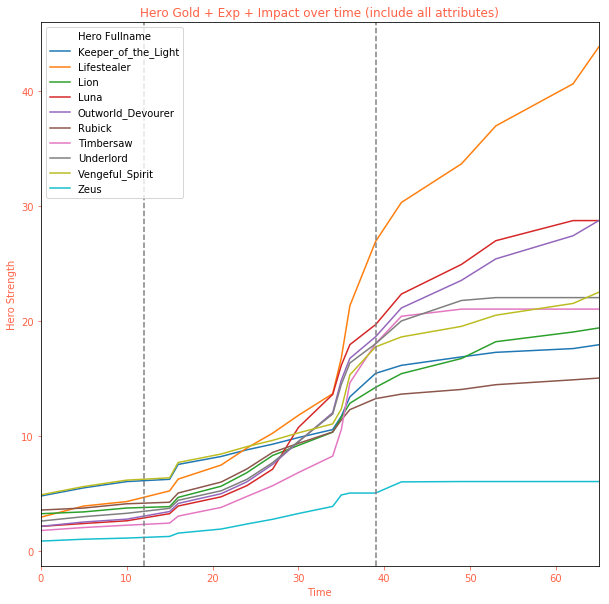

In [146]:
plt.figure()
hero_impact_chart.plot(figsize=(10,10))
plt.title(label='Hero Gold + Exp + Impact over time (include all attributes)', color='tomato')
plt.tick_params(axis='y', colors='tomato')
plt.tick_params(axis='x', colors='tomato')
plt.ylabel('Hero Strength', color = 'tomato', horizontalalignment='center')
plt.xlabel('Time', color = 'tomato', horizontalalignment='center')
plt.axvline(x=game_time_end_early, color='gray',linestyle='--')
plt.axvline(x=end_midgame_combat['stage'].max(), color='gray',linestyle='--')
plt.show();

### Plot: Team Strength Difference

In [147]:
team_diff = pd.pivot_table(combined_plot, values='Level', index=['stage'], columns=['team'], aggfunc=np.sum)
team_diff['difference'] = team_diff['radiant'] - team_diff['dire']
team_diff_plot = team_diff.groupby(['stage'])['difference'].sum()

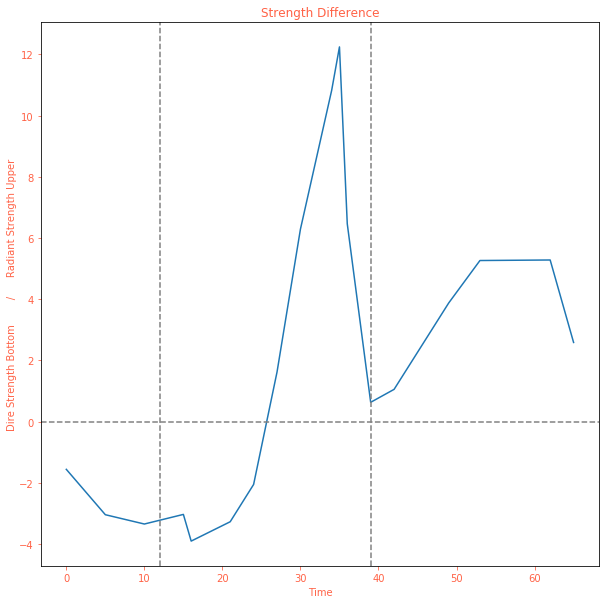

In [148]:
plt.figure(figsize=(10,10))
plt.plot(team_diff_plot)
plt.title(label='Strength Difference', color='tomato')
plt.tick_params(axis='y', colors='tomato')
plt.tick_params(axis='x', colors='tomato')
plt.ylabel('Dire Strength Bottom        /      Radiant Strength Upper', color = 'tomato', verticalalignment='baseline')
plt.xlabel('Time', color = 'tomato', horizontalalignment='center')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=game_time_end_early, color='gray',linestyle='--')
plt.axvline(x=end_midgame_combat['stage'].max(), color='gray',linestyle='--')
plt.show();